In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
from six.moves import urllib
from sklearn.metrics import roc_curve

# Import Data files

In [5]:
df_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df_eval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = df_train.pop("survived")
y_eval = df_eval.pop("survived")
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


# Data Preparation

A few steps are required before we train a Linear Classifier with Tensorflow. We need to prepare features to be included in the model. The estimator needs to have a list of features to train the model. Hence, the column's data requires to be converted into a tensor.

In [6]:
columns = [column for column in df_train.columns]
categorical_columns = [column for column in df_train.columns if df_train[column].dtype=='object']
numerical_columns = list(set(columns)-set(categorical_columns))

We use feature_column.categorical_column_with_vocabulary_list(key, vocabulary_list) when our inputs are in string or integer format, and we have an in-memory vocabulary mapping each value to an integer ID. By default, out-of-vocabulary values are ignored. 

This is because we cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector. The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

For input dictionary features, features[key] is either Tensor or SparseTensor. If Tensor, missing values can be represented by -1 for int and '' for string, which will be dropped by this feature column.

In [8]:
features = []
for column in columns:
  if column in categorical_columns:
    vocabulary = df_train[column].unique()
    features.append(fc.categorical_column_with_vocabulary_list(column, vocabulary))
  else:
    features.append(fc.numeric_column(column, dtype=tf.float32))

We need a function that constructs the input data for evaluation. As per the TensorFlow2.0 api docs,  the evaluate function should construct and return one of the following: * A tf.data.Dataset object: Outputs of Dataset object must be a tuple (features, labels) with same constraints as below. * A tuple (features, labels): Where features is a tf.Tensor or a dictionary of string feature name to Tensor and labels is a Tensor or a dictionary of string label name to Tensor. Both features and labels are consumed by model_fn. They should satisfy the expectation of model_fn from inputs.

Now, we will wrap the dataframes with tf.data. 

Below is a utility function that creates a tf.data.Dataset object from a Pandas Dataframe. It creates tensor slices of tuples of (features, labels) as required. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. 

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def transform_fn(df, label, epochs=10, shuffle=True, batch_size=32):
  def transform():
    batch_data = tf.data.Dataset.from_tensor_slices((dict(df), label))
    if shuffle:
      batch_data = batch_data.shuffle(123)
    batch_data = batch_data.batch(batch_size).repeat(epochs)
    return batch_data
  return transform

In [10]:
input_train_fn = transform_fn(df_train, y_train)
input_eval_fn = transform_fn(df_eval, y_eval, epochs=1, shuffle=False)

# Model creation

Now, we train a linear model to classify instances. feature_columns requires an iterable containing all the feature columns used by the model. 

In [11]:
est = tf.estimator.LinearClassifier(feature_columns=features)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpij116e1l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
est.train(input_train_fn)
result = est.evaluate(input_eval_fn)
clear_output()
for key in result:
  print(f"{key}: {result[key]}")

accuracy: 0.7727272510528564
accuracy_baseline: 0.625
auc: 0.8427915573120117
auc_precision_recall: 0.7847241759300232
average_loss: 0.4843689203262329
label/mean: 0.375
loss: 0.4713835120201111
precision: 0.729411780834198
prediction/mean: 0.31684190034866333
recall: 0.6262626051902771
global_step: 200


In [15]:
pred_dict = list(est.predict(input_eval_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dict])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpij116e1l/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


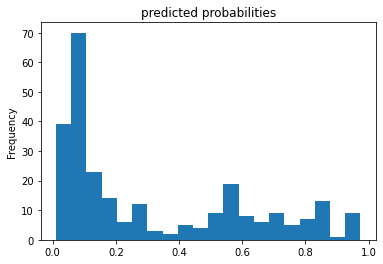

In [16]:
probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

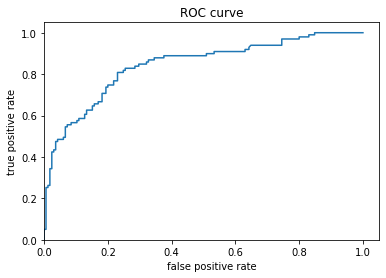

In [17]:
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)